# Курсовой проект

### <a id='table_of_contents'>Оглавление:</a>
[Функции и классы](#funcs)

1. [Загрузка данных](#first_link)
2. [Разведочный анализ данных](#second_link)
- 2.1 [Обработка выбросов:](#third_link)
- - [Признак Rooms](#rooms)
- - [Признак Square](#square)
- - [Признак KitchenSquare](#kitchen_square)
- - [Признак LifeSquare](#life_square)
- - [Признаки Floor, HouseFloor](#floor)
- - [Признак HouseYear](#year)
- 2.2 [Обработка пропусков](#fourth_link)
- 2.3 [Построение новых признаков](#fifth_link)
- 2.4 [Отбор признаков](#sixth_link)
3. [Разбиение на train и test](#seventh_link)
4. [Построение модели](#eighth_link)
5. [Прогнозирование на тестовом датасете](#ninth_link)

In [1]:
import os
import os.path as path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score as r2

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 10})

### <a id='funcs'>Функции и классы</a>
[В начало](#table_of_contents)

In [4]:
def show_base_info(sign):
    is_nan = train_df[f'{sign}'].isna().sum()
    quantile_higher = train_df[f'{sign}'].quantile(.975)
    quantile_lower = train_df[f'{sign}'].quantile(.025)
    print(f'''Количество провусков в признаке {sign}: {is_nan}\n0.975 квантиль признака {sign} равен: {quantile_higher}\n0.025 квантиль признака {sign} равен: {quantile_lower}''')

In [5]:
class DataPreprocessing:
    """Подготовка данных."""
    
    def __init__(self):
        """Параметры класса."""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистики."""
        # Расчёт медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        pass
    
    def transform(self, X):
        """Подготовка данных"""
        
        # Rooms
        X['Rooms_outliner'] = 0
        X.loc[(X.Rooms == 0) | (X.Rooms >= 6), 'Rooms_outliner'] = 1
        X.loc[(X.Rooms == 0) & (X.Square <= 43), 'Rooms'] = 1
        X.loc[(X.Rooms == 0) & (X.Square >= 83), 'Rooms'] = 3
        X.loc[(X.Rooms == 0), 'Rooms'] = 2
        X.loc[X.Rooms >= 6, 'Rooms'] = 2
        
        # Square
        X.loc[~X.Square.between(15, 200), 'Square'] = X.Square.median()
        
        # KitchenSquare
        anomaly = (X.KitchenSquare > 20) & (X.Square < X.LifeSquare + X.KitchenSquare)
        X['KitchenSquare_outliner'] = 0
        X.loc[anomaly, 'KitchenSquare_outliner'] = 1
        X[anomaly] = X.KitchenSquare.median()
        bigger_than_square = (((X.Square < X.LifeSquare + X.KitchenSquare)) | (X.LifeSquare < X.KitchenSquare)) & (X.KitchenSquare > 20)
        X.loc[(bigger_than_square), ['KitchenSquare', 'KitchenSquare_outliner']] = X.KitchenSquare.median(), 1
        X[X.KitchenSquare > 20]

        # LifeSquare
        life_square_false = (X.LifeSquare > X.Square) | (X.Square < X.LifeSquare + X.KitchenSquare)
        X['LifeSquare_outliner'] = 0
        X.loc[life_square_false, 'LifeSquare_outliner'] = 1
        life_square_false = (X.LifeSquare > X.Square) | (X.Square < X.LifeSquare + X.KitchenSquare)
        X.loc[life_square_false, 'LifeSquare'] = X[life_square_false].Square - X[life_square_false].KitchenSquare - 2
        
        # Floor, HouseFloor
        X['HouseFloor_outliner'] = 0
        X.loc[X.HouseFloor == 0, 'HouseFloor_outliner'] = 1
        X.loc[X.Floor > X.HouseFloor, 'HouseFloor_outliner'] = 1
        X.loc[X.HouseFloor > 50, ['HouseFloor', 'HouseFloor_outliner']] = X.HouseFloor.median(), 1
        
        zero_higher_median = (X.HouseFloor == 0) & (X.Floor > X.HouseFloor.median())
        X.loc[zero_higher_median, ['HouseFloor']] = X.loc[zero_higher_median].Floor

        zero_lower_median = (X.HouseFloor == 0) & (X.Floor <= X.HouseFloor.median())
        X.loc[zero_lower_median, ['HouseFloor']] = X.HouseFloor.median()

        higher_median = (X.Floor > X.HouseFloor) & (X.Floor > X.HouseFloor.median())
        X.loc[higher_median, ['HouseFloor']] = X.loc[higher_median].Floor

        lower_median = (X.Floor > X.HouseFloor) & (X.Floor <= X.HouseFloor.median())
        X.loc[lower_median, ['HouseFloor']] = X.HouseFloor.median()
        
        # HouseYear
        X.loc[X.HouseYear > 2020, 'HouseYear'] = 2020
        
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna())
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        X.drop('Healthcare_1', axis=1, inplace=True)
        
        return X
    

In [6]:
class FeatureGenerator:
    """Генератор новых признаков"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_yer = None
        self.house_year_max = None
        self.floor_max = None
        
    def transform(self, X, y=None):
        
        X = X.copy()
        
        binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_2'] = X.Ecology_2.replace(binary_to_numbers)
        X['Ecology_3'] = X.Ecology_2.replace(binary_to_numbers)
        X['Shops_2'] = X.Shops_2.replace(binary_to_numbers)

        X.convert_dtypes().dtypes
        
        district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
        X = X.merge(district_size, on='DistrictId', how='left')
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        return X

In [7]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    # Расчёт коэфициента R2 на тренировочных и тестовых данных и отображение их на графике.
    
    print(f"Train R2:\t{str(round(r2(train_true_values, train_pred_values), 3))}")
    print(f"Test R2:\t{str(round(r2(test_true_values, test_pred_values), 3))}")
    
    plt.figure(figsize=(18, 10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.show()

In [8]:
# Пути к наборам данных.

WORKING_DIRECTORY = os.getcwd()
PATH_TO_TRAIN_DATASET = path.join(WORKING_DIRECTORY, 'data','train.csv')
PATH_TO_TEST_DATASET = path.join(WORKING_DIRECTORY, 'data','test.csv')

### <a id='first_link'>Загрузка данных</a>
[В начало](#table_of_contents)

#### Материалы к проекту:
* **train.csv** - тренировочные данные
* **test.csv** - тестовые данные

#### Описание датасета:
* **id** - идентификационный номер квартиры
* **Districtid** - идентификационный номер района
* **Rooms** - количество комнат в квартире
* **Square** - общая площадь квартиры
* **LifeSquare** - площадь жилого помещения
* **KitchenSquare** - площадь кухни
* **Floor** - этаж на котором расположена квартира
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Healthcare** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием ьагазиновб торговых центров
* **Price** - цена квартиры

In [9]:
# Загрузка тренировачных данных.
train_df = pd.read_csv(PATH_TO_TRAIN_DATASET)
train_df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217


In [10]:
# Загрузка тестовых данных.
test_df = pd.read_csv(PATH_TO_TEST_DATASET)
test_df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B


### <a id='second_link'>Разведочный анализ данных.</a>
[В начало](#table_of_contents)

In [11]:
print(f'Строк в train_df: {train_df.shape[0]}')
print(f'Строк в test_df: {test_df.shape[0]}')

Строк в train_df: 10000
Строк в test_df: 5000


In [12]:
# Тип данных признаков и количество не нулевых записей.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [13]:
# Преобразование Id-идентификатора к типу str, так как данный признак 
# не несёт смысловой нагрузки полезной для анализа.
train_df.Id = train_df.Id.astype(str)

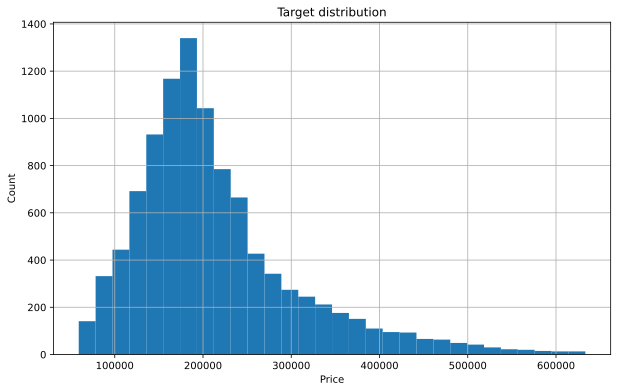

In [14]:
# Распределение целевой переменной. Близко к нормальному.
plt.figure(figsize=(10,6))
train_df.Price.hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

<Axes: >

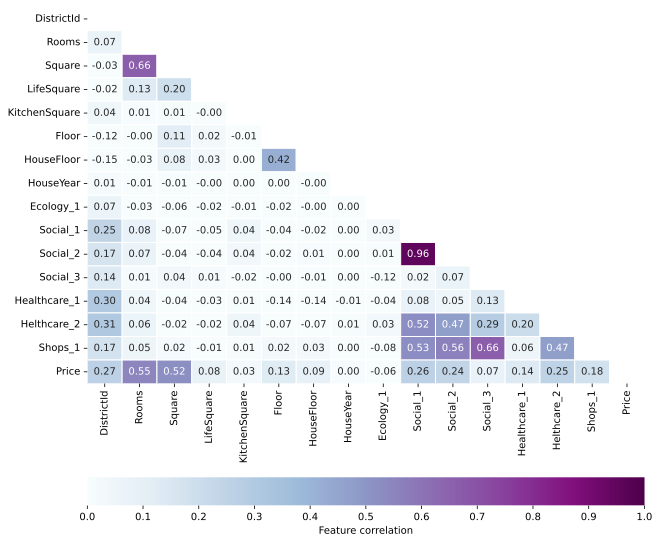

In [15]:
# Корреляция признаков.
corr = train_df.corr()
plt.figure(figsize=(10, 10))
matrix = np.triu(corr)
sns.heatmap(corr,
            annot=True,
            linewidths=1,
            fmt='.2f',
            cmap='BuPu',
            mask=matrix,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Feature correlation',
                      'orientation': 'horizontal',
                      'pad': 0.17,
                      'ticks': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
                     }
           )


In [16]:
# Преобразование DistrictId-идентификатора района к типу str, так как данный признак 
# не несёт смысловой нагрузки полезной для анализа выбросов.
train_df.DistrictId = train_df.DistrictId.astype(str)

In [17]:
# Статистика по количественным признакам.
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Square'}>,
        <Axes: title={'center': 'LifeSquare'}>,
        <Axes: title={'center': 'KitchenSquare'}>,
        <Axes: title={'center': 'Floor'}>],
       [<Axes: title={'center': 'HouseFloor'}>,
        <Axes: title={'center': 'HouseYear'}>,
        <Axes: title={'center': 'Ecology_1'}>,
        <Axes: title={'center': 'Social_1'}>,
        <Axes: title={'center': 'Social_2'}>],
       [<Axes: title={'center': 'Social_3'}>,
        <Axes: title={'center': 'Healthcare_1'}>,
        <Axes: title={'center': 'Helthcare_2'}>,
        <Axes: title={'center': 'Shops_1'}>,
        <Axes: title={'center': 'Price'}>]], dtype=object)

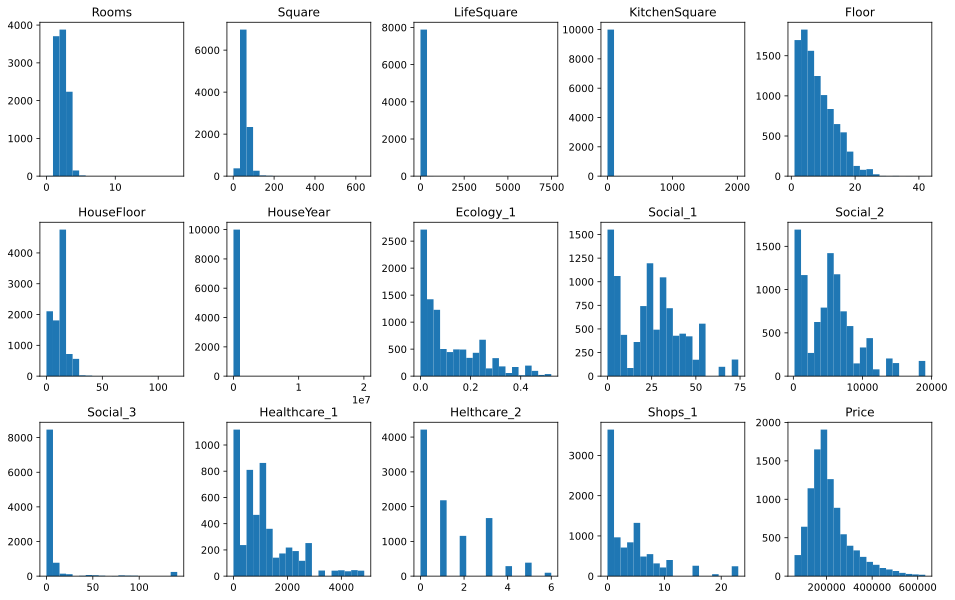

In [18]:
train_df.hist(figsize=(16,10), bins=20, layout=(3,5), grid=False)

#### Номинативные признаки
Проверяем номинативные признаки и их соотношение.

In [19]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [20]:
train_df.DistrictId.value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [21]:
train_df.Ecology_2.value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [22]:
train_df.Ecology_3.value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [23]:
train_df.Shops_2.value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### <a id='third_link'>Обработка выбросов.</a>
Устраняем выбросы в признаках.

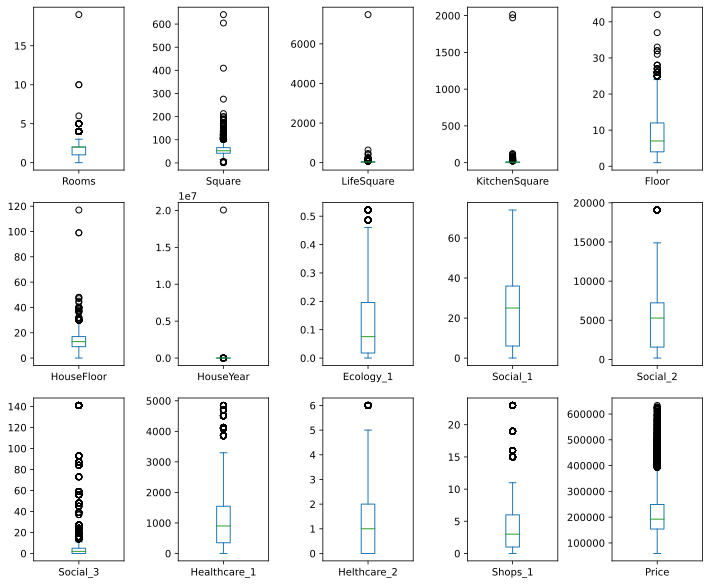

In [24]:
# Определение выбрасов.
train_df.plot(kind='box', subplots=True, layout=(3,5), sharex=False, sharey=False, figsize=(12,10))
plt.subplots_adjust(wspace=0.6, hspace=0.2)
plt.show()

#### <a id='rooms'>Признак Rooms</a>
[В начало](#table_of_contents)

In [25]:
train_df.Rooms.value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [26]:
show_base_info('Rooms')

Количество провусков в признаке Rooms: 0
0.975 квантиль признака Rooms равен: 3.0
0.025 квантиль признака Rooms равен: 1.0


In [27]:
train_df[train_df.Rooms == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


In [28]:
train_df['Rooms_outliner'] = 0
train_df.loc[(train_df.Rooms == 0) | (train_df.Rooms >= 6), 'Rooms_outliner'] = 1
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliner
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.930730,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531644,0
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,B,35,7715,4,990.0,0,6,B,215898.447742,0
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,...,B,20,4386,14,NaN,1,5,B,296021.204377,0
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,221244.156664,0
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,229102.795999,0
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,...,B,6,1437,3,NaN,0,2,B,95380.220993,0


In [29]:
train_df['Rooms_outliner'].value_counts()

0    9988
1      12
Name: Rooms_outliner, dtype: int64

In [30]:
train_df[train_df.Rooms == 1].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outliner
count,3705.0,3705.000000,2827.000000,3705.000000,3705.000000,3705.000000,3.705000e+03,3705.000000,3705.000000,3705.00000,3705.000000,1804.000000,3705.000000,3705.000000,3705.000000,3705.0
mean,1.0,41.323277,25.159008,6.525776,8.684480,13.077463,7.398392e+03,0.122414,23.470175,5108.68583,7.272874,1087.676275,1.202159,3.983266,159850.800729,0.0
std,0.0,11.427651,14.202326,46.385219,5.270649,6.823064,3.293979e+05,0.122182,17.866805,4068.20106,23.371513,954.820718,1.458162,4.754359,51892.475206,0.0
min,1.0,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.00000,0.000000,30.000000,0.000000,0.000000,60502.583500,0.0
25%,1.0,36.692587,19.681268,1.000000,4.000000,9.000000,1.977000e+03,0.019509,5.000000,1564.00000,0.000000,520.000000,0.000000,0.000000,128711.103732,0.0
50%,1.0,40.406590,21.663929,6.000000,8.000000,14.000000,1.977000e+03,0.075779,23.000000,5148.00000,1.000000,830.000000,1.000000,3.000000,154979.497993,0.0
75%,1.0,43.565368,24.232240,8.000000,12.000000,17.000000,2.004000e+03,0.211401,35.000000,7065.00000,4.000000,1406.000000,2.000000,5.000000,182212.201038,0.0
max,1.0,409.425181,410.639749,2014.000000,37.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.00000,141.000000,4849.000000,6.000000,23.000000,594565.299770,0.0


In [31]:
train_df[train_df.Rooms == 2].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outliner
count,3880.0,3880.000000,3052.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,2105.000000,3880.000000,3880.000000,3880.000000,3880.0
mean,2.0,56.788214,35.971895,5.636340,8.262113,12.151289,1983.616237,0.119468,24.516753,5292.674227,8.944845,1163.751544,1.363402,4.244072,215256.306416,0.0
std,0.0,16.846588,17.609078,4.745274,5.116141,6.839639,51.256126,0.119195,17.076349,3873.198401,25.301524,1023.998205,1.510947,4.910172,73452.209126,0.0
min,2.0,5.497061,0.795539,0.000000,1.000000,0.000000,1914.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028,0.0
25%,2.0,47.873232,29.915166,1.000000,4.000000,7.000000,1970.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,174516.718850,0.0
50%,2.0,55.841812,32.552134,6.000000,7.000000,12.000000,1977.000000,0.075779,25.000000,5285.000000,2.000000,990.000000,1.000000,3.000000,200320.754636,0.0
75%,2.0,63.324705,36.042817,8.000000,11.000000,17.000000,1996.000000,0.195781,35.000000,7077.000000,5.000000,1548.000000,3.000000,5.000000,243492.283228,0.0
max,2.0,641.065193,638.163193,78.000000,42.000000,117.000000,4968.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,0.0


In [32]:
train_df[train_df.Rooms == 3].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outliner
count,2235.0,2235.000000,1842.000000,2235.00000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,2235.000000,1193.000000,2235.000000,2235.000000,2235.000000,2235.0
mean,3.0,76.903234,54.942865,6.80179,8.766443,12.729754,1985.162864,0.112118,26.510962,5744.710515,7.561521,1167.323554,1.412975,4.512304,289337.962452,0.0
std,0.0,15.725388,174.162604,6.39015,5.316150,6.424716,18.691611,0.113613,17.529748,4060.595099,21.762023,1092.797683,1.504369,4.667667,104456.463546,0.0
min,3.0,4.390331,0.641822,0.00000,1.000000,0.000000,1916.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,64298.216337,0.0
25%,3.0,65.995703,43.679015,1.00000,4.000000,9.000000,1975.000000,0.019509,11.000000,2514.000000,0.000000,262.000000,0.000000,1.000000,218501.022386,0.0
50%,3.0,77.413643,46.960480,7.00000,8.000000,14.000000,1977.000000,0.072158,25.000000,5569.000000,2.000000,830.000000,1.000000,4.000000,268723.157677,0.0
75%,3.0,83.215957,51.669754,10.00000,12.000000,17.000000,2001.000000,0.175055,37.000000,7715.000000,5.000000,1575.000000,3.000000,6.000000,349766.968934,0.0
max,3.0,190.857689,7480.592129,123.00000,27.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,627525.072788,0.0


75% однокомнатных квартир имеют площадь меньше 43 и 75% однокомнатных квартир имеют площадь меньше 83.
Заполним объекты со значением Rooms == 0 в этом промежутке значением 2. У объектов со значением Square ниже 43 заменим признак Rooms на 1,
у объектов со значением Square выше 83 заменим признак Rooms на 3.

In [33]:
train_df.loc[train_df.Rooms == 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliner
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,...,B,66,10573,1,1322.0,3,8,B,229661.964416,1


In [34]:
train_df.loc[(train_df.Rooms == 0) & (train_df.Square <= 43), 'Rooms'] = 1
train_df.loc[(train_df.Rooms == 0) & (train_df.Square >= 83), 'Rooms'] = 3
train_df.loc[(train_df.Rooms == 0), 'Rooms'] = 2
train_df.loc[train_df.Rooms >= 6, 'Rooms'] = 2
train_df.Rooms.value_counts()

2.0    3886
1.0    3708
3.0    2238
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [35]:
train_df.Rooms.value_counts()

2.0    3886
1.0    3708
3.0    2238
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### <a id='square'>Признак Square</a>
[В начало](#table_of_contents)

In [36]:
squares = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare']

In [37]:
show_base_info('Square')

Количество провусков в признаке Square: 0
0.975 квантиль признака Square равен: 100.90624548226137
0.025 квантиль признака Square равен: 32.10518291149681


In [38]:
train_df.Square.describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [39]:
# Проверяем выбросы со значением Square менее 15 и более 200
train_df[(~train_df.Square.between(15, 200)) & (train_df.KitchenSquare < 26)][squares]

,Rooms,Square,LifeSquare,KitchenSquare
212,2.0,5.497061,67.628717,1.0
1316,1.0,4.633498,1.969969,1.0
1608,1.0,2.596351,4.604943,1.0
1981,3.0,212.932361,211.231125,0.0
3280,1.0,4.380726,40.805837,1.0
3413,1.0,5.129222,5.549458,1.0
4262,2.0,604.705972,NaN,1.0
4690,1.0,409.425181,410.639749,10.0
4739,3.0,13.784865,15.988889,7.0
4853,1.0,2.377248,0.873147,0.0


In [40]:
# Удаляем выбросы со значением от 200 и более (за исключением индекса 1982, его значения предположительно нормальны)
train_df.drop(train_df[(~train_df.Square.between(15, 200)) & (train_df.KitchenSquare < 26)].index, axis=0, inplace=True)

#### <a id='kitchen_square'>Признак KitchenSquare</a>
[В начало](#table_of_contents)

In [41]:
show_base_info('KitchenSquare')

Количество провусков в признаке KitchenSquare: 0
0.975 квантиль признака KitchenSquare равен: 13.0
0.025 квантиль признака KitchenSquare равен: 0.0


In [42]:
train_df.KitchenSquare.describe()

count    9982.000000
mean        6.278301
std        28.585252
min         0.000000
25%         1.000000
50%         6.000000
75%         9.000000
max      2014.000000
Name: KitchenSquare, dtype: float64

In [43]:
anomaly = (train_df.KitchenSquare > 20) & (train_df.Square < train_df.LifeSquare + train_df.KitchenSquare)

train_df['KitchenSquare_outliner'] = 0
train_df.loc[anomaly, 'KitchenSquare_outliner'] = 1

train_df[anomaly] = train_df.KitchenSquare.median()

In [44]:
train_df[train_df.KitchenSquare > 20][squares]

,Rooms,Square,LifeSquare,KitchenSquare
622,3.0,92.473796,53.649526,22.0
1804,1.0,98.727990,49.781722,22.0
1982,5.0,275.645284,233.949309,26.0
2656,4.0,151.150660,98.187482,23.0
3368,1.0,168.086347,125.486563,30.0
3431,2.0,139.070296,89.787666,42.0
5087,4.0,185.906396,84.830074,31.0
5494,2.0,106.427686,34.230415,32.0
5653,1.0,80.606246,25.299592,29.0
5888,2.0,64.859242,NaN,62.0


In [45]:
life_square, kitchen_square = train_df.loc[6036].KitchenSquare, train_df.loc[6036].LifeSquare
train_df.loc[6036, ['KitchenSquare', 'LifeSquare', 'KitchenSquare_outliner']] = kitchen_square, life_square, 1

In [46]:
kitchen_square, life_square = train_df.loc[5888].Square - train_df.loc[5888].KitchenSquare, train_df.loc[5888].KitchenSquare
train_df.loc[5888, ['KitchenSquare', 'LifeSquare', 'KitchenSquare_outliner']] = kitchen_square, life_square, 1

In [47]:
bigger_than_square = (((train_df.Square < train_df.LifeSquare + train_df.KitchenSquare)) | (train_df.LifeSquare < train_df.KitchenSquare)) & (train_df.KitchenSquare > 20)
train_df.loc[(bigger_than_square), ['KitchenSquare', 'KitchenSquare_outliner']] = train_df.KitchenSquare.median(), 1
train_df[train_df.KitchenSquare > 20]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliner,KitchenSquare_outliner
622,12924,30,3.0,92.473796,53.649526,22.0,3,2.0,2018,0.000078,...,22,6398,141,1046.0,3,23,B,165521.195968,0,0
1804,11459,79,1.0,98.727990,49.781722,22.0,18,24.0,2019,0.050756,...,24,5469,1,145.0,0,1,B,351021.797311,0,0
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,...,31,7010,5,4508.0,3,7,B,455264.882666,0,0
2656,14556,183,4.0,151.150660,98.187482,23.0,6,7.0,1912,0.037316,...,32,6748,93,562.0,4,10,B,284884.959104,0,0
3368,6674,54,1.0,168.086347,125.486563,30.0,18,28.0,2011,0.006076,...,30,5285,0,645.0,6,6,B,367353.574566,0,0
3431,7111,27,2.0,139.070296,89.787666,42.0,5,3.0,2016,0.014073,...,2,475,0,NaN,0,0,B,153946.777452,0,0
5087,15947,129,4.0,185.906396,84.830074,31.0,5,3.0,2015,0.020741,...,24,5613,5,1340.0,2,5,B,340273.238253,0,0
5494,300,31,2.0,106.427686,34.230415,32.0,4,40.0,2013,0.151346,...,32,5889,10,830.0,4,1,B,624549.354546,0,0
6988,8685,62,5.0,124.933289,81.122369,30.0,5,3.0,2017,0.072158,...,2,629,1,NaN,0,0,A,271919.866048,0,0
7201,3233,129,4.0,186.692602,87.487080,32.0,3,3.0,2011,0.020741,...,24,5613,5,1340.0,2,5,B,423443.464367,0,0


#### <a id='life_square'>Признак LifeSquare</a>
[В начало](#table_of_contents)

In [48]:
show_base_info('LifeSquare')

Количество провусков в признаке LifeSquare: 2111
0.975 квантиль признака LifeSquare равен: 80.2373887014379
0.025 квантиль признака LifeSquare равен: 6.0


In [49]:
train_df.LifeSquare.describe()

count    7871.000000
mean       36.889109
std        85.898544
min         0.370619
25%        22.713202
50%        32.700670
75%        45.051668
max      7480.592129
Name: LifeSquare, dtype: float64

In [50]:
train_df[train_df.LifeSquare > 100][squares]

,Rooms,Square,LifeSquare,KitchenSquare
44,3.0,104.211396,106.340403,0.0
343,3.0,125.287183,127.477137,19.0
358,3.0,121.844004,122.497641,1.0
506,1.0,105.432181,106.178175,0.0
590,2.0,48.449873,263.542020,5.0
652,3.0,190.857689,107.376164,19.0
1397,3.0,138.427694,136.215499,0.0
1641,1.0,174.649522,174.837082,15.0
1686,3.0,103.683549,102.886556,1.0
1746,3.0,108.137587,105.920260,1.0


In [51]:
life_square_false = (train_df.LifeSquare > train_df.Square) | (train_df.Square < train_df.LifeSquare + train_df.KitchenSquare)

train_df['LifeSquare_outliner'] = 0
train_df.loc[life_square_false, 'LifeSquare_outliner'] = 1

In [52]:
# Ищем значения LifeSquare больше Square и заменяем на разность Square и KitchenSquare
life_square_false = (train_df.LifeSquare > train_df.Square) | (train_df.Square < train_df.LifeSquare + train_df.KitchenSquare)
train_df.loc[life_square_false, 'LifeSquare'] = train_df[life_square_false].Square - train_df[life_square_false].KitchenSquare - 2
train_df[life_square_false]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliner,KitchenSquare_outliner,LifeSquare_outliner
3,5809,58,2.0,53.352981,42.352981,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.227217,0,0,1
28,8054,23,1.0,42.530043,39.530043,1.0,3,9.0,2014,0.034656,...,168,0,NaN,0,0,B,95338.198549,0,0,1
44,10521,38,3.0,104.211396,102.211396,0.0,20,0.0,2017,0.060753,...,2787,2,520.0,0,7,B,435462.048070,0,0,1
48,7596,23,1.0,47.080100,33.080100,12.0,3,9.0,1977,0.014073,...,475,0,NaN,0,0,B,96029.167877,0,0,1
52,2301,1,2.0,61.400054,59.400054,0.0,17,22.0,2016,0.007122,...,264,0,NaN,0,1,B,199215.452229,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,6.0,6.0,6.0,6.000000,-2.000000,6.0,6,6.0,6,6.000000,...,6,6,6.0,6,6,6.0,6.000000,6,6,1
9897,4497,1,1.0,38.330353,28.330353,8.0,7,17.0,1991,0.025609,...,5261,0,240.0,3,1,B,97464.327338,0,0,1
9902,14001,73,1.0,44.098768,41.098768,1.0,7,24.0,2014,0.042032,...,6856,84,1940.0,2,5,B,381937.404161,0,0,1
9918,14904,34,4.0,104.049130,92.049130,10.0,8,25.0,2018,0.069753,...,13670,4,NaN,1,11,B,411971.106869,0,0,1


#### <a id='floor'>Признак Floor, HouseFloor</a>
[В начало](#table_of_contents)

In [53]:
floor_signs = ['Floor', 'HouseFloor']

In [54]:
show_base_info('Floor')

Количество провусков в признаке Floor: 0
0.975 квантиль признака Floor равен: 21.0
0.025 квантиль признака Floor равен: 2.0


In [55]:
show_base_info('HouseFloor')

Количество провусков в признаке HouseFloor: 0
0.975 квантиль признака HouseFloor равен: 25.0
0.025 квантиль признака HouseFloor равен: 0.0


In [56]:
train_df.Floor.describe()

count    9982.000000
mean        8.515328
std         5.221582
min         1.000000
25%         4.000000
50%         7.000000
75%        12.000000
max        42.000000
Name: Floor, dtype: float64

In [57]:
train_df.HouseFloor.describe()

count    9982.000000
mean       12.596073
std         6.767996
min         0.000000
25%         9.000000
50%        12.000000
75%        17.000000
max       117.000000
Name: HouseFloor, dtype: float64

In [58]:
train_df.Floor.sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [59]:
train_df.HouseFloor.sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [60]:
train_df['HouseFloor_outliner'] = 0
train_df.loc[train_df.HouseFloor == 0, 'HouseFloor_outliner'] = 1
train_df.loc[train_df.Floor > train_df.HouseFloor, 'HouseFloor_outliner'] = 1

In [61]:
# Количество значений Floor больше HouseFloor
(train_df.Floor > train_df.HouseFloor).sum()

1810

In [62]:
train_df.loc[train_df.HouseFloor > 50, ['HouseFloor', 'HouseFloor_outliner']] = train_df.HouseFloor.median(), 1

In [63]:
train_df[(train_df.HouseFloor == 0) & (train_df.Floor <= train_df.HouseFloor.median())]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliner,KitchenSquare_outliner,LifeSquare_outliner,HouseFloor_outliner
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,...,0,645.0,6,6,B,571069.052600,0,0,0,1
65,11398,62,1.0,41.194188,NaN,0.0,6,0.0,1977,0.072158,...,1,NaN,0,0,A,114063.092041,0,0,0,1
70,10362,27,2.0,79.227049,NaN,0.0,9,0.0,1977,0.072158,...,1,NaN,0,0,A,167023.973143,0,0,0,1
223,4622,27,2.0,62.153994,36.094352,0.0,5,0.0,1977,0.072158,...,1,NaN,0,0,A,194091.992560,0,0,0,1
252,8139,27,2.0,58.553809,NaN,0.0,7,0.0,1977,0.072158,...,1,NaN,0,0,A,177511.314827,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9606,12136,1,1.0,51.953707,NaN,0.0,2,0.0,1977,0.007122,...,0,NaN,0,1,B,148682.719427,0,0,0,1
9628,14936,27,3.0,103.587261,NaN,0.0,8,0.0,1977,0.072158,...,1,NaN,0,0,A,225901.938089,0,0,0,1
9707,12302,30,1.0,46.072913,44.072913,0.0,4,0.0,1977,0.000078,...,141,1046.0,3,23,B,161403.094034,0,0,1,1
9878,11441,62,2.0,71.985335,69.985335,0.0,5,0.0,1977,0.072158,...,1,NaN,0,0,A,158841.624543,0,0,1,1


In [64]:
zero_higher_median = (train_df.HouseFloor == 0) & (train_df.Floor > train_df.HouseFloor.median())
train_df.loc[zero_higher_median, ['HouseFloor']] = train_df.loc[zero_higher_median].Floor

zero_lower_median = (train_df.HouseFloor == 0) & (train_df.Floor <= train_df.HouseFloor.median())
train_df.loc[zero_lower_median, ['HouseFloor']] = train_df.HouseFloor.median()

higher_median = (train_df.Floor > train_df.HouseFloor) & (train_df.Floor > train_df.HouseFloor.median())
train_df.loc[higher_median, ['HouseFloor']] = train_df.loc[higher_median].Floor

lower_median = (train_df.Floor > train_df.HouseFloor) & (train_df.Floor <= train_df.HouseFloor.median())
train_df.loc[lower_median, ['HouseFloor']] = train_df.HouseFloor.median()

In [65]:
train_df[train_df.HouseFloor_outliner == 1].shape

(1813, 24)

#### <a id='year'>Признак HouseYear</a>
[В начало](#table_of_contents)

In [66]:
show_base_info('HouseYear')

Количество провусков в признаке HouseYear: 0
0.975 квантиль признака HouseYear равен: 2018.0
0.025 квантиль признака HouseYear равен: 1958.0


In [67]:
train_df.HouseYear.sort_values(ascending=False)

1497    20052011
4189        4968
3485        2020
4376        2020
8253        2020
          ...   
8232           6
8584           6
4110           6
4588           6
9895           6
Name: HouseYear, Length: 9982, dtype: int64

In [68]:
train_df[train_df.HouseYear > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliner,KitchenSquare_outliner,LifeSquare_outliner,HouseFloor_outliner
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,10,262.0,3,6,B,254084.534396,0,0,0,0
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,...,16,2857.0,5,8,B,243028.603096,0,0,0,0


In [69]:
train_df.loc[train_df.HouseYear > 2020, 'HouseYear'] = 2020

### <a id='fourth_link'>Обработка пропусков.</a>
[В начало](#table_of_contents)

In [70]:
# Количество пропусков.
train_df.isna().sum()

Id                           0
DistrictId                   0
Rooms                        0
Square                       0
LifeSquare                2111
KitchenSquare                0
Floor                        0
HouseFloor                   0
HouseYear                    0
Ecology_1                    0
Ecology_2                    0
Ecology_3                    0
Social_1                     0
Social_2                     0
Social_3                     0
Healthcare_1              4764
Helthcare_2                  0
Shops_1                      0
Shops_2                      0
Price                        0
Rooms_outliner               0
KitchenSquare_outliner       0
LifeSquare_outliner          0
HouseFloor_outliner          0
dtype: int64

In [71]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1
condition = (train_df['LifeSquare'].isna())
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] - 3

In [72]:
train_df.LifeSquare.isna().sum()

0

В колонке признака Healthcare_1 пропущено около половины значений. В данном случае этот признак целесообразно удалить.

In [73]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [74]:
train_df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliner,KitchenSquare_outliner,LifeSquare_outliner,HouseFloor_outliner,LifeSquare_nan
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,0,11,B,184966.930730,0,0,0,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,1,16,B,300009.450063,0,0,0,0,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,0,1,3,B,220925.908524,0,0,0,0,0
3,5809,58,2.0,53.352981,42.352981,9.0,8,17.0,1977,0.437885,...,3,0,5,B,175616.227217,0,0,1,0,0


### <a id='fifth_link'>Построение новых признаков.</a>
[В начало](#table_of_contents)

Dummies

In [75]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df.Ecology_2.replace(binary_to_numbers)
train_df['Ecology_3'] = train_df.Ecology_2.replace(binary_to_numbers)
train_df['Shops_2'] = train_df.Shops_2.replace(binary_to_numbers)

train_df.convert_dtypes().dtypes

Id                         object
DistrictId                 object
Rooms                       Int64
Square                    Float64
LifeSquare                Float64
KitchenSquare             Float64
Floor                       Int64
HouseFloor                  Int64
HouseYear                   Int64
Ecology_1                 Float64
Ecology_2                   Int64
Ecology_3                   Int64
Social_1                    Int64
Social_2                    Int64
Social_3                    Int64
Helthcare_2                 Int64
Shops_1                     Int64
Shops_2                     Int64
Price                     Float64
Rooms_outliner              Int64
KitchenSquare_outliner      Int64
LifeSquare_outliner         Int64
HouseFloor_outliner         Int64
LifeSquare_nan              Int64
dtype: object

DistrictSize, IsDistrictLarge

In [76]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,836
1,1,650
2,23,563
3,6,509
4,9,293


In [77]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outliner,KitchenSquare_outliner,LifeSquare_outliner,HouseFloor_outliner,LifeSquare_nan,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,1.0,184966.930730,0,0,0,0,0,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,1.0,300009.450063,0,0,0,0,0,87
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,1,3,1.0,220925.908524,0,0,0,0,0,174
3,5809,58,2.0,53.352981,42.352981,9.0,8,17.0,1977,0.437885,...,0,5,1.0,175616.227217,0,0,1,0,0,177
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,1.0,150226.531644,0,0,0,0,0,97


In [78]:
(train_df['DistrictSize'] > 100).value_counts()

True     5036
False    4946
Name: DistrictSize, dtype: int64

In [79]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outliner,KitchenSquare_outliner,LifeSquare_outliner,HouseFloor_outliner,LifeSquare_nan,DistrictSize,IsDistrictLarge
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,11,1.0,184966.930730,0,0,0,0,0,22,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,16,1.0,300009.450063,0,0,0,0,0,87,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,3,1.0,220925.908524,0,0,0,0,0,174,1
3,5809,58,2.0,53.352981,42.352981,9.0,8,17.0,1977,0.437885,...,5,1.0,175616.227217,0,0,1,0,0,177,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,4,1.0,150226.531644,0,0,0,0,0,97,0


MedPriceByDistrict

In [80]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'MedPriceByDistrict'})
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,6.0,6.0,6.000000
1,0,1.0,142799.434052
2,0,2.0,176210.812334
3,0,3.0,300610.359425
4,1,1.0,146574.015522


In [81]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outliner,KitchenSquare_outliner,LifeSquare_outliner,HouseFloor_outliner,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,1.0,184966.930730,0,0,0,0,0,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1.0,300009.450063,0,0,0,0,0,87,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,1.0,220925.908524,0,0,0,0,0,174,1,263206.223152
3,5809,58,2.0,53.352981,42.352981,9.0,8,17.0,1977,0.437885,...,1.0,175616.227217,0,0,1,0,0,177,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1.0,150226.531644,0,0,0,0,0,97,0,158539.052715


### <a id='sixth_link'>Отбор признаков.</a>
[В начало](#table_of_contents)

In [82]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outliner',
 'KitchenSquare_outliner',
 'LifeSquare_outliner',
 'HouseFloor_outliner',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [83]:
feature_name = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']
new_feature_name = ['Rooms_outliner', 'KitchenSquare_outliner', 'LifeSquare_outliner', 'HouseFloor_outliner', 'LifeSquare_nan', 'DistrictSize', 'IsDistrictLarge', 'MedPriceByDistrict']
target_name = 'Price'

### <a id='seventh_link'>Разбиение на train и test.</a>
[В начало](#table_of_contents)

Загрузка чистых данных.

In [84]:
train_df = pd.read_csv(PATH_TO_TRAIN_DATASET)
test_df = pd.read_csv(PATH_TO_TEST_DATASET)

Устранение выбросов.

In [85]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

In [86]:
f_gen = FeatureGenerator()
train_df = f_gen.transform(train_df)
test_df = f_gen.transform(test_df)

In [87]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [88]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)


In [89]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 25), (3300, 25), (5000, 25))

### <a id='eighth_link'>Построение модели.</a>
[В начало](#table_of_contents)

In [90]:
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Rooms_outliner,KitchenSquare_outliner,LifeSquare_outliner,HouseFloor_outliner,LifeSquare_nan,DistrictSize,IsDistrictLarge
9239,14100,93,1.0,39.458190,21.630224,8.0,9,17.0,1985,0.050900,...,2,3,1.0,0,0,0,0,0,73,0
6930,13906,26,1.0,57.088640,23.298211,10.0,4,30.0,2014,0.000000,...,0,2,1.0,0,0,0,0,0,65,0
8136,715,44,1.0,32.777610,22.448450,5.0,8,9.0,1967,0.036122,...,1,1,1.0,0,0,0,0,0,104,1
3424,3518,37,1.0,37.752079,20.140014,10.0,6,15.0,1976,0.127812,...,1,3,1.0,0,0,0,0,0,72,0
6518,10941,23,1.0,31.702237,27.702237,1.0,14,14.0,1977,0.034656,...,0,0,1.0,0,0,0,1,1,563,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,7845,8,1.0,38.476449,23.803304,9.0,16,16.0,1971,0.092291,...,1,2,1.0,0,0,0,1,0,142,1
48,7596,23,1.0,47.080100,33.080100,12.0,3,9.0,1977,0.014073,...,0,0,1.0,0,0,1,0,0,563,1
8964,13776,1,3.0,74.132699,45.351233,10.0,10,17.0,2009,0.025609,...,3,1,1.0,0,0,0,0,0,652,1
5944,15646,46,2.0,63.911398,33.784613,12.0,2,17.0,2004,0.188784,...,0,1,1.0,0,0,0,0,0,118,1


In [91]:
from sklearn.ensemble import RandomForestRegressor 
rf_model = RandomForestRegressor(random_state=21, criterion='squared_error')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Train R2:	0.962
Test R2:	0.732


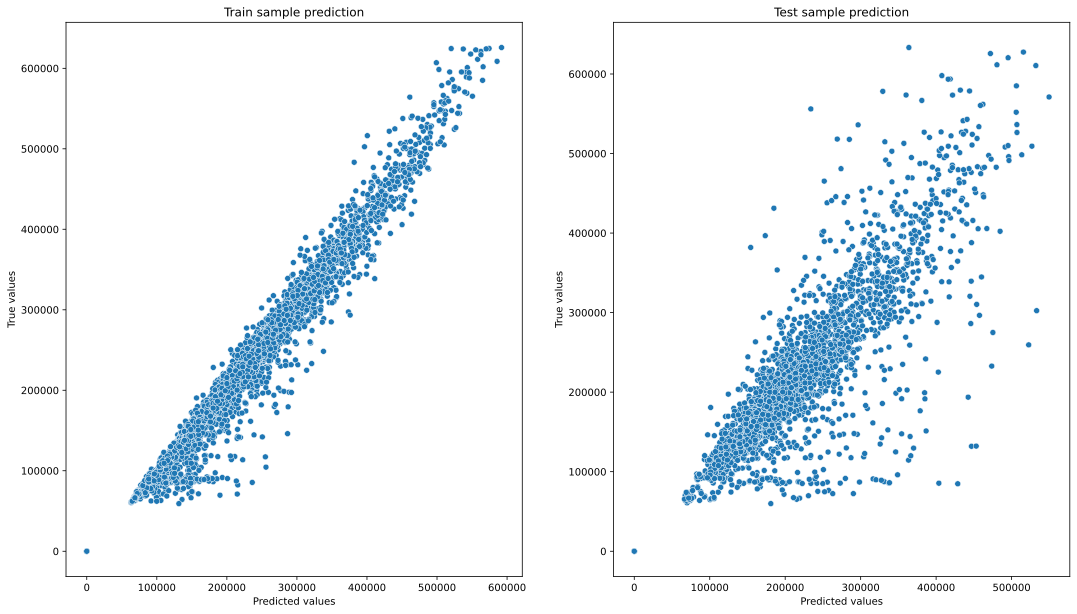

In [92]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_pred, y_valid, y_test_pred)

### <a id='ninth_link'>Прогнозирование на тестовом датасете.</a>
[В начало](#table_of_contents)

In [93]:
test_df.shape

(5000, 25)

In [94]:
predictions = rf_model.predict(test_df)
predictions

array([197082.87206333, 210513.20569972, 316701.08995359, ...,
       354927.19927655, 246791.63806427, 444238.89808327])

In [95]:
result = test_df.copy()
result['Price'] = predictions
result[['Id', 'Price']].to_csv('DBudilov_predictions.csv', index=False)